In [65]:
import numpy as np
import linearmodels
from linearmodels import PanelOLS
from linearmodels import OLS
import statsmodels.api as sm
import numpy as np
import linearmodels
from linearmodels import IV2SLS 
from linearmodels import IVGMM
from linearmodels import OLS

## Let's import our csv containing our data as a dataframe. It is cross sectional data consisting of 131 countries over 11 years (2006-2016 inclusive). 

In [3]:
import numpy as np
import pandas as pd

data = pd.read_csv(r'C:\Users\Viral Shanker\Desktop\Combined2016new3.csv')
data.head()
j = (pd.get_dummies(data["code"]))
data1 = pd.concat([data, j], axis = 1)
j = data1.columns
j.drop("BOL")
cs = j[97:]
t = ['2', '3', '4', '5', '6', '7', '8', '9', '10', '11']
data["logInvestment"] = np.log(data["Investment"])

C:\Users\Viral Shanker\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in log
  if sys.path[0] == '':


In [5]:
exog = ["Ethnic",  "INEQUALITY", "tradePerGDP", "URBAN",  "dCIVILWARS", "Resources", "dOIL", "dBRITISH",  "dDutch", "dFRENCH", "dSPAN", "dLATINAME", "dLANDLOCKED", "dAfrica", 'dASIAN_OUT_OF_MIDEAST', "dMIDEAST", "dPOSTSOVIET", "dWENA",
       '2', '3', '4', '5', '6', '7', '8', '9', '10', '11']

## Let's try our naive OLS regression. log(Income per capita) regressed on democracy, law and order and a constant. 

* Note that we are using log(income_per_capita) as traditionally monetary values such as income per capita and investment are logged so as to convert it into almost a growth rate. 
* EIU is the Economist's measure of democracy. It is not an unbiased measure of democracatic institutions like say the [Polity IV](https://www.systemicpeace.org/polity/polity4.htm) but also includes cultural aspects like apathy toward government and trust (see [EIU methodology on pg 48](https://www.prensa.com/politica/democracy-index_LPRFIL20190112_0001.pdf)). 
* LAW is rule of law as taken from [here](http://info.worldbank.org/governance/wgi/Home/Documents). The reason to include this is to seperate general stability from democratic processes, as otherwise democracy would capture that effect, as cultural attributes like EIU includes are correlated significantly with general stability and rule of law, which in turn of course, is highly correlatd with income. 

In [79]:
mod = OLS(data.LN_INCOMEPC, data[["eiu", "LAW", "constant"]])
res = mod.fit()
res.summary

C:\Users\Viral Shanker\Anaconda3\lib\site-packages\linearmodels\utility.py:454: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


<class 'linearmodels.compat.statsmodels.Summary'>
"""
                            OLS Estimation Summary                            
==============================================================================
Dep. Variable:            LN_INCOMEPC   R-squared:                      0.6972
Estimator:                        OLS   Adj. R-squared:                 0.6967
No. Observations:                1420   F-statistic:                    5884.2
Date:                Sat, Oct 19 2019   P-value (F-stat)                0.0000
Time:                        15:57:56   Distribution:                  chi2(2)
Cov. Estimator:                robust                                         
                                                                              
                             Parameter Estimates                              
==============================================================================
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
eiu            0.1216     0.0208     5.8356     0.0000      0.0808      0.1624
LAW            4.6173     0.1703     27.113     0.0000      4.2835      4.9510
constant       5.2779     0.0690     76.437     0.0000      5.1426      5.4132
==============================================================================
"""

## We have oth law and democracy being positively correlated with inome. Law far more so with a massive t-statistic, but democracy also is very definitely positive and very significant. Let's try without law and do a basic regression of income on democracy

In [81]:
mod = OLS(data.LN_INCOMEPC, data[["eiu", "constant"]])
res = mod.fit()
res.summary

C:\Users\Viral Shanker\Anaconda3\lib\site-packages\linearmodels\utility.py:454: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


<class 'linearmodels.compat.statsmodels.Summary'>
"""
                            OLS Estimation Summary                            
==============================================================================
Dep. Variable:            LN_INCOMEPC   R-squared:                      0.5359
Estimator:                        OLS   Adj. R-squared:                 0.5355
No. Observations:                1420   F-statistic:                    1558.8
Date:                Sat, Oct 19 2019   P-value (F-stat)                0.0000
Time:                        16:15:32   Distribution:                  chi2(1)
Cov. Estimator:                robust                                         
                                                                              
                             Parameter Estimates                              
==============================================================================
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
eiu            0.5247     0.0133     39.482     0.0000      0.4987      0.5508
constant       5.4002     0.0909     59.416     0.0000      5.2220      5.5783
==============================================================================
"""

# As expected, we get a strong positive correlation, and a very significant one at that. Let's Visualize it:

C:\Users\Viral Shanker\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


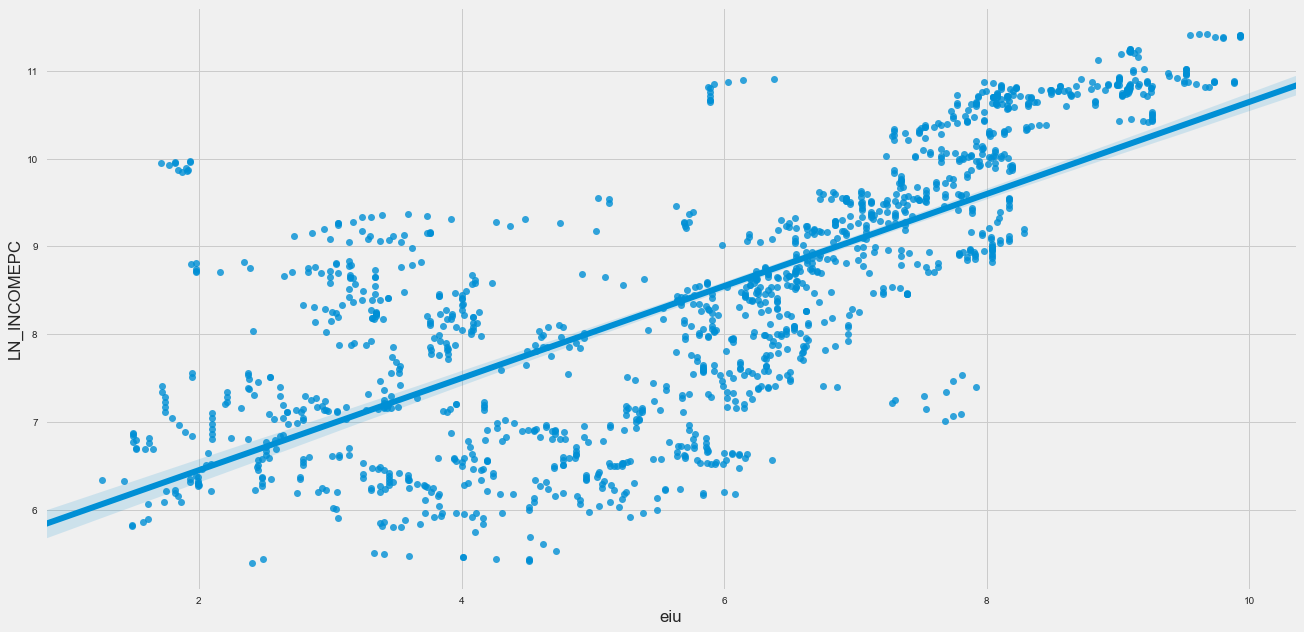

In [82]:
import seaborn as sns
from matplotlib import pyplot as plt
plt.style.use("fivethirtyeight")
fig = plt.figure(figsize=(20,10))
sns.regplot(x = "eiu", y = "LN_INCOMEPC", data=data)

## Right off the bat, some issues are obvious. First of all, we're treating every country/year combination as independant. For instance,  2006 Russia is bound to be similar to 2007 Russia. So Let's try and account for the time-effects, and see what results we get. This means we have dummy variables for each year. 
* Note that we drop the dummy variable of year 1 to avoid the dummy variable trap. 

In [13]:
mod = OLS(data.LN_INCOMEPC, data[["eiu", "constant",'2', '3', '4', '5', '6', '7', '8', '9', '10', '11']])
res = mod.fit()
res.summary

C:\Users\Viral Shanker\Anaconda3\lib\site-packages\linearmodels\utility.py:454: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


<class 'linearmodels.compat.statsmodels.Summary'>
"""
                            OLS Estimation Summary                            
==============================================================================
Dep. Variable:            LN_INCOMEPC   R-squared:                      0.5375
Estimator:                        OLS   Adj. R-squared:                 0.5339
No. Observations:                1420   F-statistic:                    1571.4
Date:                Sat, Oct 19 2019   P-value (F-stat)                0.0000
Time:                        14:00:43   Distribution:                 chi2(11)
Cov. Estimator:                robust                                         
                                                                              
                             Parameter Estimates                              
==============================================================================
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
eiu            0.5246     0.0133     39.493     0.0000      0.4986      0.5506
constant       5.2954     0.1256     42.174     0.0000      5.0493      5.5415
2              0.0336     0.1308     0.2571     0.7971     -0.2227      0.2900
3              0.0459     0.1303     0.3525     0.7245     -0.2095      0.3013
4              0.0517     0.1297     0.3983     0.6904     -0.2025      0.3058
5              0.1091     0.1298     0.8407     0.4005     -0.1453      0.3635
6              0.1174     0.1303     0.9009     0.3677     -0.1380      0.3727
7              0.1274     0.1297     0.9821     0.3260     -0.1268      0.3816
8              0.1419     0.1299     1.0920     0.2748     -0.1128      0.3966
9              0.1571     0.1292     1.2158     0.2241     -0.0962      0.4104
10             0.1689     0.1292     1.3072     0.1911     -0.0843      0.4221
11             0.2067     0.1287     1.6063     0.1082     -0.0455      0.4590
==============================================================================
"""

## Almost no change in terms of our predictions. Let's throw law back in.

In [85]:
mod = OLS(data.LN_INCOMEPC, data[["eiu", "LAW", "constant",'2', '3', '4', '5', '6', '7', '8', '9', '10', '11']])
res = mod.fit()
res.summary

C:\Users\Viral Shanker\Anaconda3\lib\site-packages\linearmodels\utility.py:454: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


<class 'linearmodels.compat.statsmodels.Summary'>
"""
                            OLS Estimation Summary                            
==============================================================================
Dep. Variable:            LN_INCOMEPC   R-squared:                      0.6995
Estimator:                        OLS   Adj. R-squared:                 0.6970
No. Observations:                1420   F-statistic:                    5896.7
Date:                Sat, Oct 19 2019   P-value (F-stat)                0.0000
Time:                        16:16:14   Distribution:                 chi2(12)
Cov. Estimator:                robust                                         
                                                                              
                             Parameter Estimates                              
==============================================================================
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
eiu            0.1197     0.0208     5.7636     0.0000      0.0790      0.1605
LAW            4.6368     0.1702     27.244     0.0000      4.3032      4.9704
constant       5.2305     0.1011     51.714     0.0000      5.0323      5.4288
2              0.0063     0.1092     0.0580     0.9537     -0.2077      0.2203
3             -0.0974     0.1085    -0.8982     0.3691     -0.3101      0.1152
4             -0.0291     0.1064    -0.2731     0.7848     -0.2376      0.1795
5              0.0208     0.1055     0.1972     0.8437     -0.1860      0.2276
6              0.0707     0.1060     0.6674     0.5045     -0.1370      0.2784
7              0.0469     0.1056     0.4438     0.6572     -0.1601      0.2538
8              0.0859     0.1052     0.8161     0.4144     -0.1204      0.2921
9              0.1222     0.1052     1.1611     0.2456     -0.0841      0.3285
10             0.1583     0.1052     1.5051     0.1323     -0.0478      0.3644
11             0.1403     0.1037     1.3531     0.1760     -0.0629      0.3435
==============================================================================
"""

## Once again, very similar results. Our time-effects do not seem to matter too much. Let's graph each country individually however. This is a bit more work as we have to average our democracy values, and we will label each country on the graph as well. 

* So let's group by country code to get average values for all our countries. Note that we now have as many rows as countries - 131. 
* Note that there are no dummies here at all, we are demeaning the data, so our graph will be different from the time-effects regression above

In [86]:
data2 = data

data2 = data2.groupby("Country", as_index = False).mean()

#### Drop Bosnia as we are missing values

In [87]:
data2 = data2[data2.Country != "Bosnia "]

### Let's do our regression again just to get an idea of what to expect

In [88]:
mod = OLS(data2.LN_INCOMEPC, data2[["eiu", "constant"]])
res = mod.fit()
res.summary

<class 'linearmodels.compat.statsmodels.Summary'>
"""
                            OLS Estimation Summary                            
==============================================================================
Dep. Variable:            LN_INCOMEPC   R-squared:                      0.5484
Estimator:                        OLS   Adj. R-squared:                 0.5449
No. Observations:                 130   F-statistic:                    151.08
Date:                Sat, Oct 19 2019   P-value (F-stat)                0.0000
Time:                        16:17:09   Distribution:                  chi2(1)
Cov. Estimator:                robust                                         
                                                                              
                             Parameter Estimates                              
==============================================================================
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
eiu            0.5321     0.0433     12.291     0.0000      0.4473      0.6170
constant       5.3603     0.2959     18.115     0.0000      4.7803      5.9402
==============================================================================
"""

# Again, very similar except for the lower t-stat - though still very significant

In [89]:
#Source of label_point function: https://stackoverflow.com/questions/46027653/adding-labels-in-x-y-scatter-plot-with-seaborn
def label_point(x, y, val, ax):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        ax.text(point['x']+.02, point['y'], str(point['val']))

C:\Users\Viral Shanker\Anaconda3\lib\site-packages\seaborn\regression.py:546: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
C:\Users\Viral Shanker\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


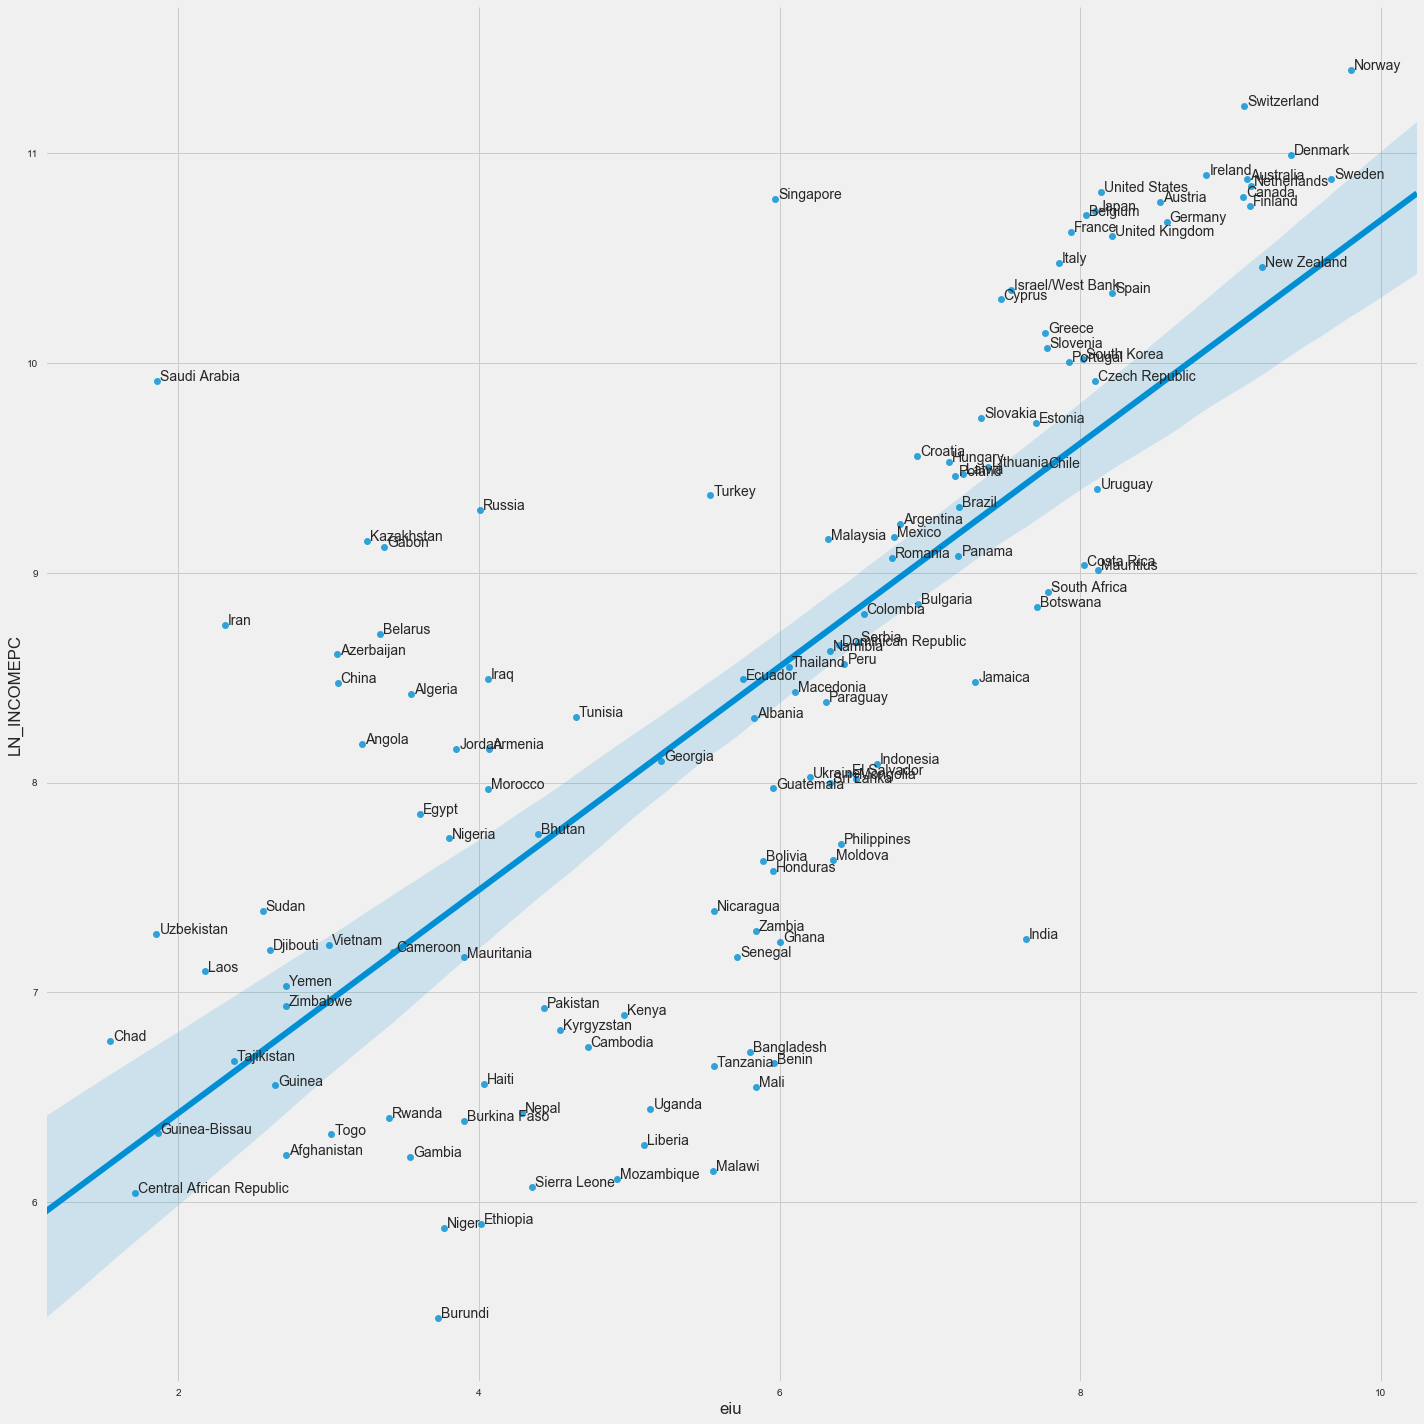

In [90]:
ax = sns.lmplot(x = "eiu", y = "LN_INCOMEPC", data=data2, size = 20)
label_point(data2.eiu, data2.LN_INCOMEPC, data2.Country, plt.gca())

## Similar graph to oyr last one, but now we can see where each country falls. We see outliers like Saudi arabia which have high income but low democracy. We also have India far below the trend line with high democratic tendencies but low income, so the relationship is hardly ubiquotous. 

### Let's do the LAW, eiu regression on averages as well, for posterity's sake

In [91]:
mod = OLS(data2.LN_INCOMEPC, data2[["eiu", "LAW", "constant"]])
res = mod.fit()
res.summary

<class 'linearmodels.compat.statsmodels.Summary'>
"""
                            OLS Estimation Summary                            
==============================================================================
Dep. Variable:            LN_INCOMEPC   R-squared:                      0.7058
Estimator:                        OLS   Adj. R-squared:                 0.7012
No. Observations:                 130   F-statistic:                    569.40
Date:                Sat, Oct 19 2019   P-value (F-stat)                0.0000
Time:                        16:29:10   Distribution:                  chi2(2)
Cov. Estimator:                robust                                         
                                                                              
                             Parameter Estimates                              
==============================================================================
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
eiu            0.1161     0.0695     1.6711     0.0947     -0.0201      0.2524
LAW            4.7102     0.5716     8.2403     0.0000      3.5899      5.8306
constant       5.2595     0.2238     23.498     0.0000      4.8209      5.6982
==============================================================================
"""

## Interesting to note that that eiu become close to insignificant here although retaining around the same t-stat. That said, given our small sample these results overall hold less value than our full-sample regressions

## Instrument Variable Regression. 

### The above methodologies make no claim at causation. it could be that there exist confounding variables - that is variables we haven't included in our regression that affect both demicracy and income per capita, which causes positive correlation but not causation. The only know way to empirically measure causation is to use some variation of the [instrumental variable regression technique](http://cameron.econ.ucdavis.edu/e240a/ch04iv.pdf). We essenttially need an instrumental variable that satisfies two conditions:

* Relevency: The IV we chose must be relevant to the endogenous (in our case, democracy) Easily tested with a simple regression

* Exclusion: (The tough one) The IV must be exogenous with respect to the y-variable (in our case, income). There is no real statistical way to test for this. One must be able to argue that this is is the case for the chose instrument

## Our Instrument: demoWar

### A simple dummy variable. A 1 if the country has gone to war with a democracy as defined by the Polity index, and a 0 otherwise. 

### Relevancy: We get a t-statistic of -9.6, which is right around where we want it to be. As a general rule of thumb, a t-stat of 10 is considered a relevant instrument. This tells us that a country having gone to war with democracy is correlated with being less democratic

In [105]:
mod = OLS(data.eiu, data[["demoWar", "constant"]])
res = mod.fit()
res.summary

C:\Users\Viral Shanker\Anaconda3\lib\site-packages\linearmodels\utility.py:454: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


<class 'linearmodels.compat.statsmodels.Summary'>
"""
                            OLS Estimation Summary                            
==============================================================================
Dep. Variable:                    eiu   R-squared:                      0.0504
Estimator:                        OLS   Adj. R-squared:                 0.0498
No. Observations:                1430   F-statistic:                    92.800
Date:                Sat, Oct 19 2019   P-value (F-stat)                0.0000
Time:                        17:26:46   Distribution:                  chi2(1)
Cov. Estimator:                robust                                         
                                                                              
                             Parameter Estimates                              
==============================================================================
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
demoWar       -1.1959     0.1241    -9.6333     0.0000     -1.4392     -0.9526
constant       5.9988     0.0632     94.930     0.0000      5.8750      6.1227
==============================================================================
"""

### Exogneity: And now we must leave the safe abode of statistics behind, and rely on logic and reasoning. 

* There is what is known as the [Democratic Peace Theory](https://www.oxfordbibliographies.com/view/document/obo-9780199756223/obo-9780199756223-0014.xml) which alleges that democracies are far less likely to go to war with another than they are to go to war with non-democracies. Here was have a channel which shows demoWar directly affecting democracy. It is important to note that this effect is exogenous of income and stability. Just the mere fact of being a democracy is enough to dissuade others from going to war with them. Hence we have our exclusion. This instrument has also been used as an instrument in several other papers exploring the same issue, like [this](https://economics.mit.edu/files/5677). 

In [97]:
sample = IVGMM(data.LN_INCOMEPC, data[["constant", "LAW"]], data[["eiu"]], data["demoWar"])
sres = sample.fit()
sres.summary

C:\Users\Viral Shanker\Anaconda3\lib\site-packages\linearmodels\utility.py:454: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


<class 'linearmodels.compat.statsmodels.Summary'>
"""
                          IV-GMM Estimation Summary                           
==============================================================================
Dep. Variable:            LN_INCOMEPC   R-squared:                      0.4395
Estimator:                     IV-GMM   Adj. R-squared:                 0.4387
No. Observations:                1420   F-statistic:                    3217.7
Date:                Sat, Oct 19 2019   P-value (F-stat)                0.0000
Time:                        17:01:42   Distribution:                  chi2(2)
Cov. Estimator:                robust                                         
                                                                              
                             Parameter Estimates                              
==============================================================================
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
constant       6.3747     0.3678     17.333     0.0000      5.6538      7.0955
LAW            9.3664     1.5128     6.1915     0.0000      6.4014      12.331
eiu           -0.5045     0.2002    -2.5205     0.0117     -0.8968     -0.1122
==============================================================================

Endogenous: eiu
Instruments: demoWar
GMM Covariance
Debiased: False
Robust (Heteroskedastic)
"""

## We see suprisingly, that democracy actually has flipped signs and turned negative! Also note that while it is still significant, it is less significant than it has been in previous regressions

## Let's try with only democracy, though again, recall that democracy will capture some of the stability part. 

In [106]:
sample = IVGMM(data.LN_INCOMEPC, data[["constant"]], data[["eiu"]], data["demoWar"])
sres = sample.fit()
sres.summary

C:\Users\Viral Shanker\Anaconda3\lib\site-packages\linearmodels\utility.py:454: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


<class 'linearmodels.compat.statsmodels.Summary'>
"""
                          IV-GMM Estimation Summary                           
==============================================================================
Dep. Variable:            LN_INCOMEPC   R-squared:                      0.4252
Estimator:                     IV-GMM   Adj. R-squared:                 0.4248
No. Observations:                1420   F-statistic:                    24.085
Date:                Sat, Oct 19 2019   P-value (F-stat)                0.0000
Time:                        17:50:28   Distribution:                  chi2(1)
Cov. Estimator:                robust                                         
                                                                              
                             Parameter Estimates                              
==============================================================================
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
constant       6.7789     0.3359     20.180     0.0000      6.1205      7.4373
eiu            0.2862     0.0583     4.9076     0.0000      0.1719      0.4006
==============================================================================

Endogenous: eiu
Instruments: demoWar
GMM Covariance
Debiased: False
Robust (Heteroskedastic)
"""

## We retain a weaker but still significant coefficient for democracy in this case.

# Flaws and Recourses.

* The main flaw in our rationale is most likely our use of LAW. It could very well be that LAW itself is endogenous, and that by not treating it as such we find biased coefficients. However considering our small sample - 11 years - it seems unlikely that LAW would be endogenous. Fixed perhaps by using something like the Polity IV index which does not capture cultural phenomenon and purely democracy, hence making it so we do not need law. 

* Small time range. It could be that democracy takes longer than 11 years to act, and perhaps over a sample of hundreds of years, the correlation of democracy and income does exist. We cannot speak beyond our sample